# Part D: Mesh Interpolation

This note book is the fourth part of the repository -- Step 2: Mesh Interpolation Matrix Building.

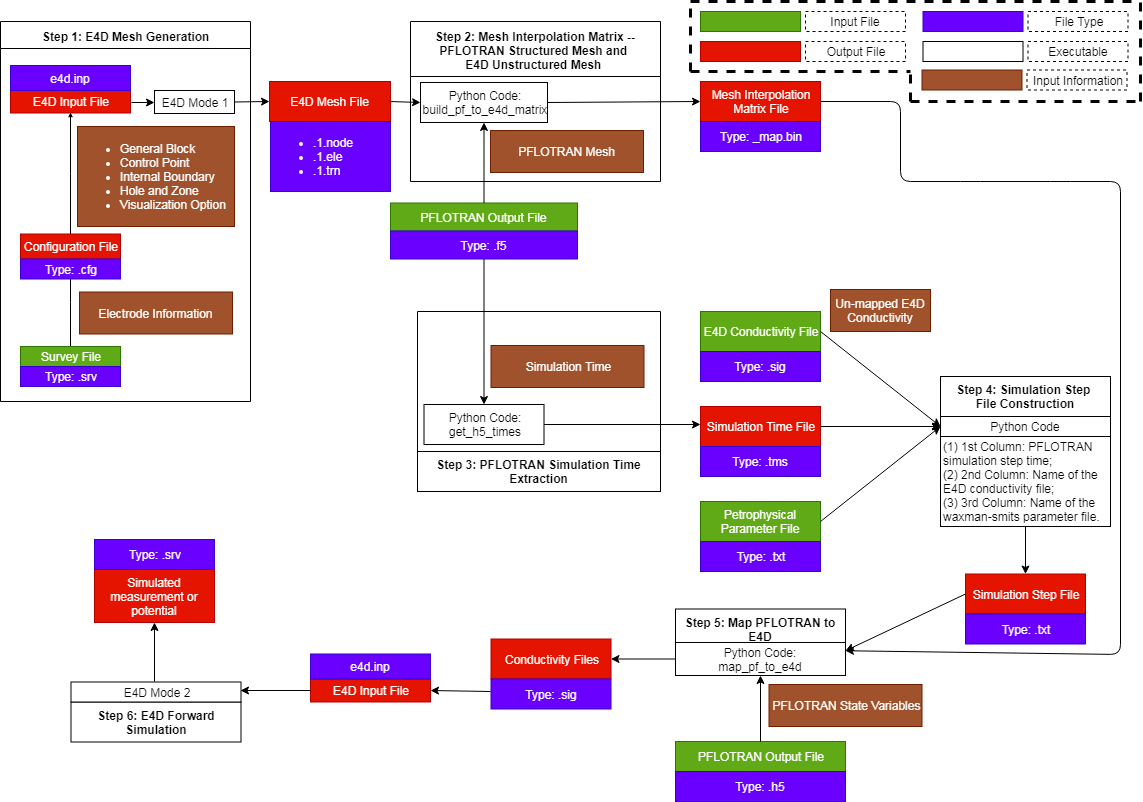

In [1]:
from IPython.display import Image
# from IPython.core.display import HTML 
Image(filename = 'Notebook_Picture/' + 'workflow_diagram.png', width=1000, height=1000)

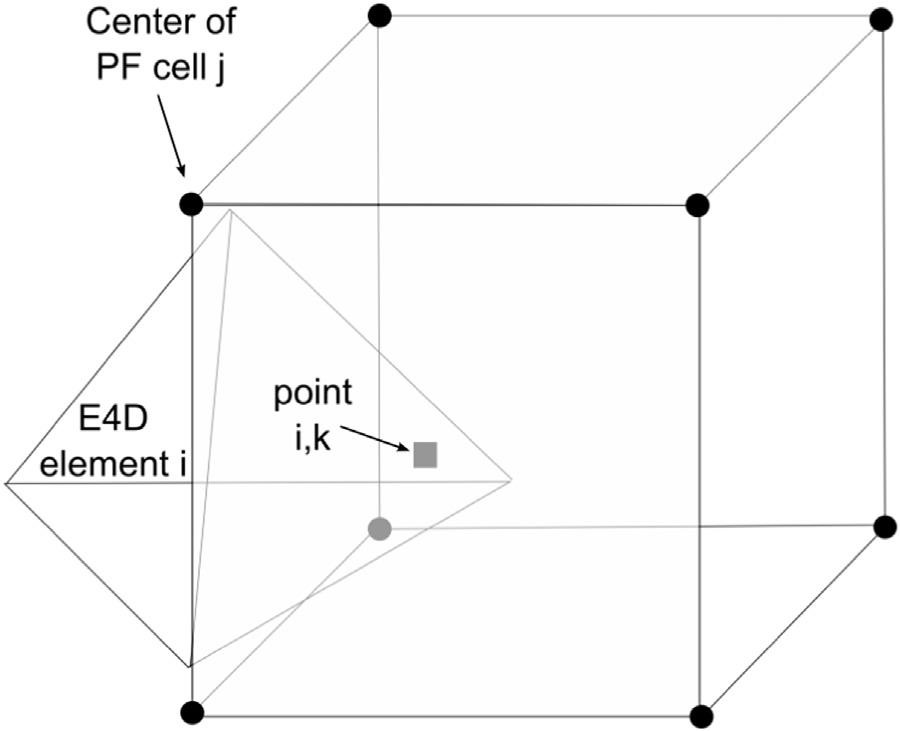

In [2]:
from IPython.display import Image
# from IPython.core.display import HTML 
Image(filename = '/global/u1/v/vthw28/PFLOTRAN_E4D_Coupling/Notebook_Picture/' + 'Mesh_Interpolation_Matrix.jpg', width=500, height=500)

At PFLOTRAN simulation step, **'Tracer', 'Fluid Saturation', 'Porosity', and 'Temperature'** are simulated and stored in the PFLOTRAN simulation result file. This section will map these states to conductivity files which can be used by E4D forward model. However, because of the incongruent aligment of PFLOTRAN and E4D mesh and the different scale of E4D mesh in different regions, we need to build a mesh interpolation matrix first. Employ a trilinear interpolation of the value at the eight PFLOTRAN cell centers surrounding that point.
$$m_{i}^{e}=\frac{1}{V_{i}} \int_{V_{i}} m^{c}(\mathbf{r}) d V \approx \frac{1}{n_{k}} \sum_{k=1}^{{n}_{k}} m_{i, k}^{c}$$
Where, $m_{i}^{e}$ -- bulk conductivity of element $i$ in the E4D mesh; $V_{i}$ -- volume of E4D mesh element $i$; $r$ -- position vector; $m^{c}$ -- bulk conductivity on the PFLOTRAN mesh; $n_{k}$ -- number of subdivisions by which E4D element $i$ is divided for the integral approximation; $m_{i, k}^{c}$ -- bulk conductivity within element $i$ and subdivision $k$. The value of $m_{i, k}^{c}$ is determined using a tri-linear interpolation of the values ${m}^{c}$ at each of the eight PFLOTRAN cell centers surrouding point $i, k$.
$$m_{i, k}^{c}=\sum_{j=1}^{n_{c}} m_{j}^{c} W_{i, j, k}$$
Where, ${n}_{c}$ -- number of elements in the PFLOTRAN mesh; $m_{j}^{c}$ -- bulk conductivity of element $j$ in the PFLOTRAN mesh; $W_{i, j, k}$ -- weight given to $m_{j}^{c}$ in determing the value of sub-element $k$ within element $i$ of the E4D mesh. Combine equations above and give the interpolation equation for an E4D mesh element $i$.
$$m_{i}^{e}=\frac{1}{n_{k}} \sum_{k=1}^{{n}_{k}} \sum_{j=1}^{n_{c}} m_{j}^{c} W_{i, j, k}$$

# 1. Pre-processing

## 1.1 Modules Import

To run the notebook, you need the packages below:<br>
   * os
   * imp
   * IPyhon
   * numpy
   * h5py
   * ipywidgets<br>
   
This step will check if all the required libraries installed or not. Package 1 to 6 are the standard libraries, which should be installed automatically. So they are not checked. If any libraries missed, the commands will install the missed libraries.

In [3]:
# Check libraries installed or not. If not, install the missed libraries.

import imp

lib_req = ['os','IPython','imp','numpy','h5py','ipywidgets']
lib_req_num = len(lib_req)

for i in range(lib_req_num):
    try:
        imp.find_module(lib_req[i])
    except ImportError:
        print(lib_req[i] + ' is not installed. Please use the relevant command below to install.')

Command to install missing packages. Delete '#' of the package you want to install.

In [4]:
#!pip install h5py --user
#!pip install ipywidgets --user

<font color = red>Tips: The commands can only detect the libraries installed via **pip** and **conda**, which include most of the libraries installed. I will try other commands to include all libraries and update.<br>
The Python version for the kernel is Python3.6 and there are some updated packages in Python3.7, which means sometimes when you run '!pip install package_name --user', you can't install that because it exists in Python3.7 but you can't import it in Python3.7. The best way is to switch your Python to 3.7 in your **'kernel-helper.sh'**. However, Python3.7 will cause some problems, not very stable, so you can install the packages in the terminal after activating your kernel: <br>
    Open a terminal, and activate the selected kernel. Then use the command: **pip install package_name**<br>
    
After that, run **import package_name** again.<br><font>

In [5]:
import os
import numpy as np
import h5py
import imp
import ipywidgets as widgets
from IPython.display import display

# Widgets style definition
style = {'description_width': '150px'}

## 1.2 Input Files Check

PartB needs some files as input. Among them, **Fortran Script Files** and **PFLOTRAN Simulation Result Files** should be provided by users. See the table below for what information these files can provide.<br>

|File|Function|Comments|
|:--:|:------:|:------:|
|Fortran Script|Compile to Python Package|'test_interp2.f90'|
|PFLOTRAN Simulation Result File|Provide Simulation time step, Tracer, Saturation, Porosity, and Temperature|Files with extension '.h5'|

In [6]:
# The path of current folder
path = os.getcwd() 

# Fortran script check
fortran_files = [f for f in os.listdir(path) if f.endswith('.f90')]
    
if 'test_interp2.f90' not in fortran_files:
    print('\x1b[0;30;41m' + 'test_interp2.f90' + '\x1b[0m', 'is not available, if you have never compiled it before, you need to upload.')
else:
    print('\x1b[0;30;42m' + 'test_interp2.f90' + '\x1b[0m', 'is available.')
    
# PFLOTRAN Simulation Result File Check
pf_output_files = [f for f in os.listdir(path) if f.endswith('.h5')]
pf_output_l = len(pf_output_files)

if pf_output_l == 0:
    print('\x1b[0;30;41m' + 'PFLOTRAN Simulation File' + '\x1b[0m', 'is not available, please upload a PFLOTRAN Simulation Result file.')
else:
    print ('\x1b[0;30;42m' + 'PFLOTRAN Simulation Result File' + '\x1b[0m', 'has been found, please select:')
    pf_output_options = widgets.RadioButtons(
        options= pf_output_files,
        description='PFLOTRAN:',
        disabled=False,
        style = style
)
    display(pf_output_options)
    
mesh_ele_files = [f for f in os.listdir(path) if f.endswith('.ele')]
ele_l = len(mesh_ele_files)
mesh_face_files = [f for f in os.listdir(path) if f.endswith('.face')]
face_l = len(mesh_face_files)
mesh_node_files = [f for f in os.listdir(path) if f.endswith('.node')]
node_l = len(mesh_node_files)
mesh_trn_files = [f for f in os.listdir(path) if f.endswith('.trn')]
trn_l = len(mesh_trn_files)

if ele_l * face_l * node_l * trn_l != 0:
    print('Please select', '\x1b[0;30;42m'+'E4D Mesh Files'+'\x1b[0m',':')
    mesh_ele_name_input = widgets.RadioButtons(
        options= mesh_ele_files,
        description='Element File:',
        disabled=False,
        style = style
    )
    mesh_node_name_input = widgets.RadioButtons(
        options= mesh_node_files,
        description='Node File:',
        disabled=False,
        style = style
    )
    mesh_face_name_input = widgets.RadioButtons(
        options= mesh_face_files,
        description='Face File:',
        disabled=False,
        style = style
    )
    mesh_trn_name_input = widgets.RadioButtons(
        options= mesh_trn_files,
        description='Translation File:',
        disabled=False,
        style = style
    )
    
    display(mesh_ele_name_input,mesh_node_name_input,mesh_face_name_input,mesh_trn_name_input)
    
else:
    print('\x1b[0;30;41m' + 'E4D Mesh Files' + '\x1b[0m', 'are not available, please upload E4D Mesh Files.')

test_interp2.f90 is available.
PFLOTRAN Simulation Result File has been found, please select:


RadioButtons(description='PFLOTRAN:', options=('pflotranR1-000.h5',), style=DescriptionStyle(description_width…

Please select E4D Mesh Files :


RadioButtons(description='Element File:', options=('e4d_mesh.1.ele',), style=DescriptionStyle(description_widt…

RadioButtons(description='Node File:', options=('e4d_mesh.1.node',), style=DescriptionStyle(description_width=…

RadioButtons(description='Face File:', options=('e4d_mesh.1.face',), style=DescriptionStyle(description_width=…

RadioButtons(description='Translation File:', options=('e4d_mesh.trn',), style=DescriptionStyle(description_wi…

In [7]:
# Read the users' selection
pf_output_file_name = pf_output_options.value
print('The selected PFLOTRAN Simulation Output file: ', '\x1b[0;30;42m' + pf_output_file_name + '\x1b[0m')

mesh_ele_name = mesh_ele_name_input.value
mesh_ele_name_len = len(mesh_ele_name)
mesh_ele_name_prefix = mesh_ele_name[0:(mesh_ele_name_len-6)]
    
mesh_node_name = mesh_node_name_input.value
mesh_node_name_len = len(mesh_node_name)
mesh_node_name_prefix = mesh_node_name[0:(mesh_node_name_len-7)]
    
mesh_face_name = mesh_face_name_input.value
mesh_face_name_len = len(mesh_face_name)
mesh_face_name_prefix = mesh_ele_name[0:(mesh_face_name_len-7)]
    
mesh_trn_name = mesh_trn_name_input.value
mesh_trn_name_len = len(mesh_trn_name)
mesh_trn_name_prefix = mesh_ele_name[0:(mesh_trn_name_len-4)]
    
if mesh_ele_name_prefix == mesh_node_name_prefix == mesh_face_name_prefix == mesh_trn_name_prefix:
    print ('The prefix of all the E4D mesh files are the same:','\x1b[0;30;42m' + mesh_ele_name_prefix + '\x1b[0m', '. Continue')
    prefix_test_interp = mesh_ele_name_prefix
else:
    print ('The prefix of E4D Mesh File are different. Please re-select the files or rename them.')

The selected PFLOTRAN Simulation Output file:  pflotranR1-000.h5
The prefix of all the E4D mesh files are the same: e4d_mesh . Continue


## 1.3 Fortran Script Compilation and Import

Compile and import the fortran scripts -- **test_interp2.f90**.<br>
The command will check if you have compiled it before. If you have compiled it before, then import it. If not, the command will compile and import it.

In [8]:
try:
    imp.find_module('test_interp2')
    print('Module test-interp2 exist and import.')
except ImportError:
    print('Module test_interp2 does not exist, compiling...')
    !module swap PrgEnv-intel PrgEnv-gnu
    !python -m numpy.f2py -c test_interp2.f90 -m test_interp2

import test_interp2

Module test-interp2 exist and import.


<font color = red>Tips: If you meet any problems of compiling or importing modules, please check if **PATH and LD_LBRARY_PATH** of selected kernel is set correctly or not. Corresponding part is the **Step 3** of the notebook **PartA_2_Kernel_Customize**.<font>

In [9]:
# Read the file and output the number of cells of PFLOTRAN Mesh in x, y, z-dimension.
f1 = h5py.File(pf_output_file_name,'r')
for ky in f1.keys():
    if(ky == "Coordinates"):
        coords = f1.get(ky)
        for k in coords.keys():
            if(k[0]=="X"):
                xnods=np.copy(coords.get(k),order='F')
                nx_nods = xnods.shape[0]
                nx_cells = nx_nods-1
            if(k[0]=="Y"):
                ynods=np.copy(coords.get(k),order='F')
                ny_nods = ynods.shape[0]
                ny_cells = ny_nods -1
            if(k[0]=="Z"):
                znods=np.copy(coords.get(k),order='F')
                nz_nods = znods.shape[0]
                nz_cells = nz_nods - 1
f1.close()
print ("Number of PF cells in x-dimension: ",nx_cells)
print ("Number of PF cells in y-dimension: ",ny_cells)
print ("Number of PF cells in z-dimension: ",nz_cells)

# Adjust nodes so that the outer cell centers are on the boundary
xnods[0]=2*xnods[0]-xnods[1]
xnods[nx_cells]=2*xnods[nx_cells]-xnods[nx_cells-1]
ynods[0]=2*ynods[0]-ynods[1]
ynods[nx_cells]=2*ynods[nx_cells]-ynods[ny_cells-1]
znods[0]=2*znods[0]-znods[1]
znods[nz_cells]=2*znods[nz_cells]-znods[nz_cells-1]

# Call the module 'test_interp2' to build the mesh interpolation matrix
test_interp2.mesh_interp(xnods,ynods,znods,prefix_test_interp)

print('Generate the mesh interpolation matrix file: ', '\x1b[0;30;42m' + prefix_test_interp +'_map.bin' + '\x1b[0m')

Number of PF cells in x-dimension:  200
Number of PF cells in y-dimension:  200
Number of PF cells in z-dimension:  40
Generate the mesh interpolation matrix file:  e4d_mesh_map.bin
